### Importing basic packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.metrics import mean_squared_error


sns.set()
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#  loading the train data
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df.head()


date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [3]:
#setting index and converting to datetime
df = df.set_index('date')
df.index = pd.to_datetime(df.index)


In [4]:
#  loading the test data
tesdf = pd.read_csv("DailyDelhiClimateTest.csv")
tesdf.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333

In [5]:
#setting index and converting to datetime
tesdf = tesdf.set_index('date')
tesdf.index = pd.to_datetime(tesdf.index)


In [6]:
df.describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [8]:
#checking for missing values

for i in df.columns:
    print("Missing Values in ", i , "is -",df[i].isna().sum())

Missing Values in  meantemp is - 0
Missing Values in  humidity is - 0
Missing Values in  wind_speed is - 0
Missing Values in  meanpressure is - 0


In [9]:
# Adding new columns; month and year
df['year'] = df.index.year
df['month'] = df.index.month
df['month_of_year'] = df.index.to_period('M')
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week


In [10]:
# Checkimg the output of the preprocessing
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   meantemp       1462 non-null   float64  
 1   humidity       1462 non-null   float64  
 2   wind_speed     1462 non-null   float64  
 3   meanpressure   1462 non-null   float64  
 4   year           1462 non-null   int64    
 5   month          1462 non-null   int64    
 6   month_of_year  1462 non-null   period[M]
 7   dayofweek      1462 non-null   int64    
 8   quarter        1462 non-null   int64    
 9   dayofyear      1462 non-null   int64    
 10  dayofmonth     1462 non-null   int64    
 11  weekofyear     1462 non-null   UInt32   
dtypes: UInt32(1), float64(4), int64(6), period[M](1)
memory usage: 144.2 KB


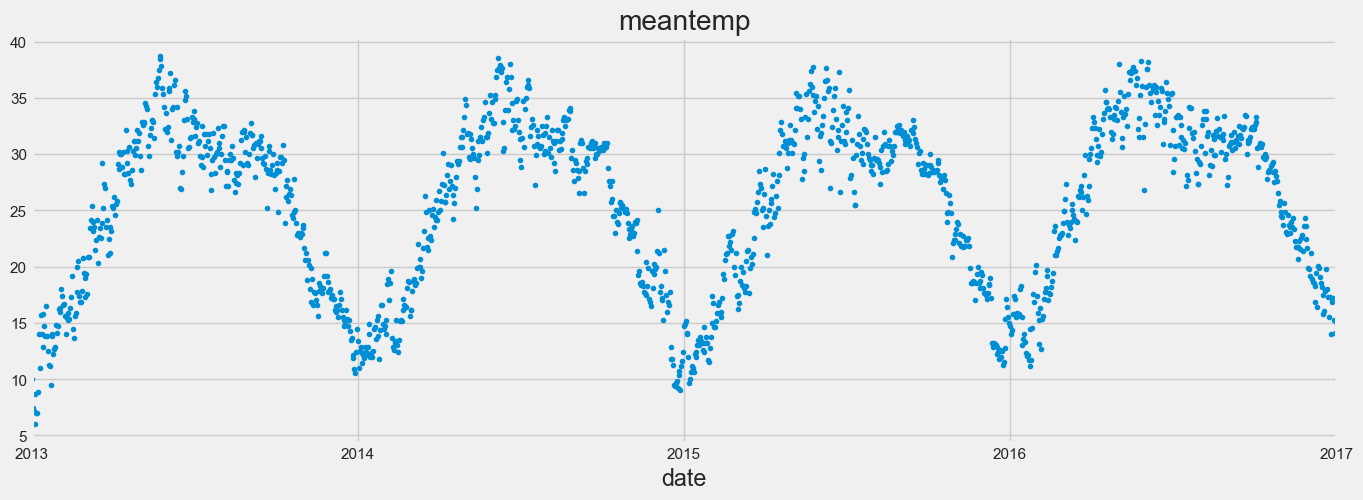

In [11]:
df['meantemp'].plot(style='.',figsize=(15, 5), title='meantemp')
plt.show()

In [12]:
# 1. Exploring the change of Temperature overtime

def plot_vars(data, x, y, year):
    fig, ax = plt.subplots(figsize=(20,10))
    
    sns.lineplot(
        ax = ax,
        data = data,
        x = x, 
        y = y,
        hue = year,
        palette = 'bright'
    )
    plt.show()
    

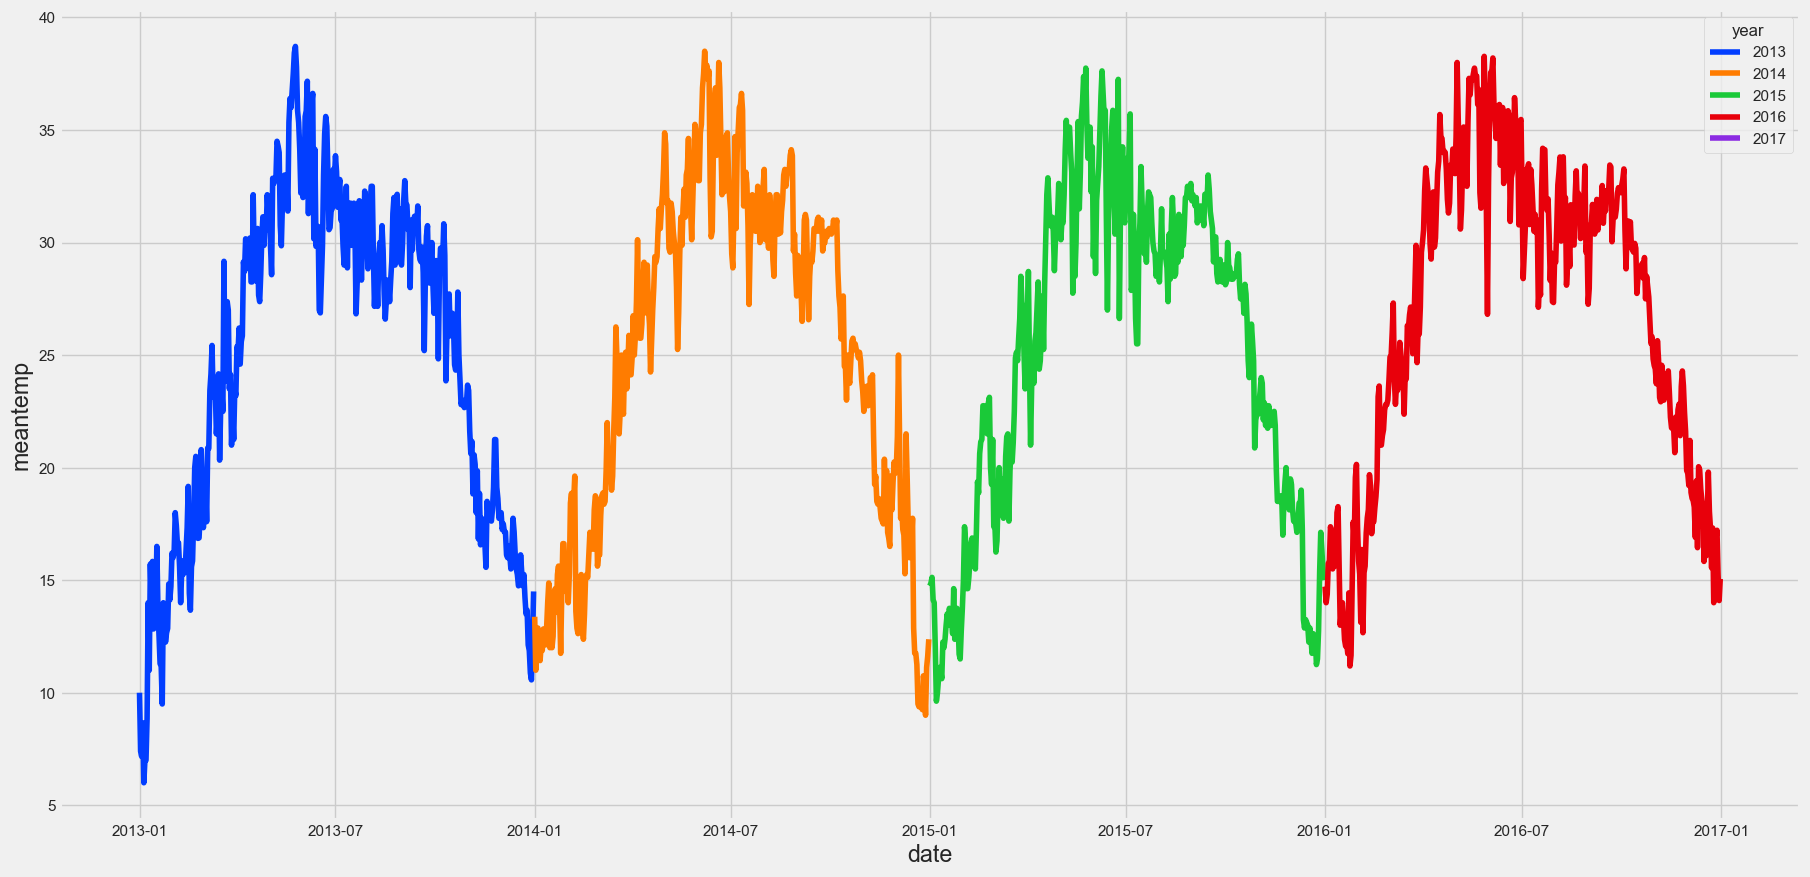

In [13]:
# 1. Exploring the change of Temprature overtime

plot_vars(df, df.index, 'meantemp', 'year')

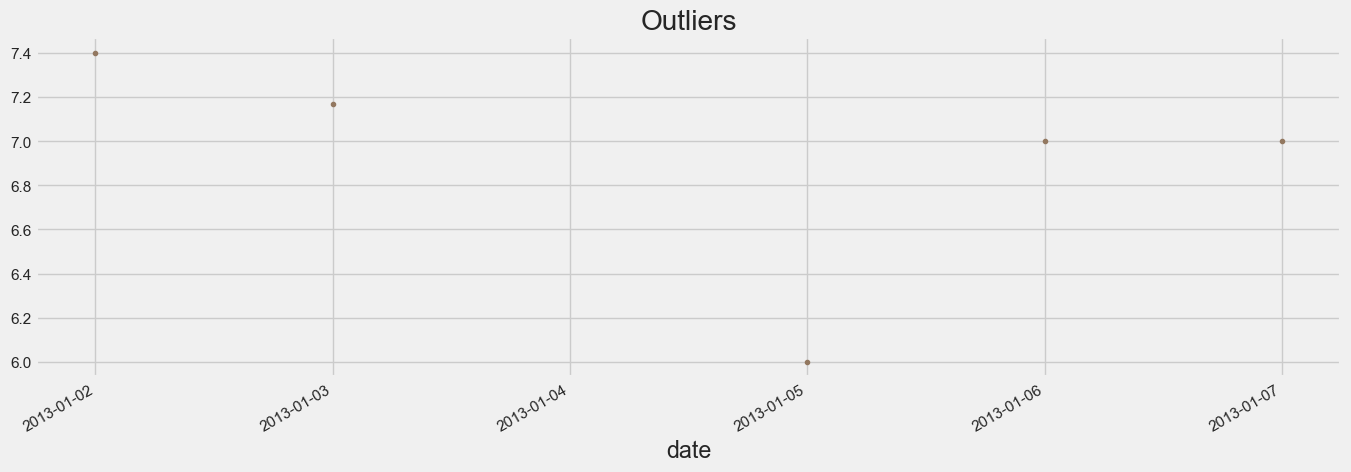

In [14]:
# checking for outliers in the train dataset

df.query('meantemp < 8')['meantemp'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers');

In [15]:
# df = df.query('meantemp > 8').copy()

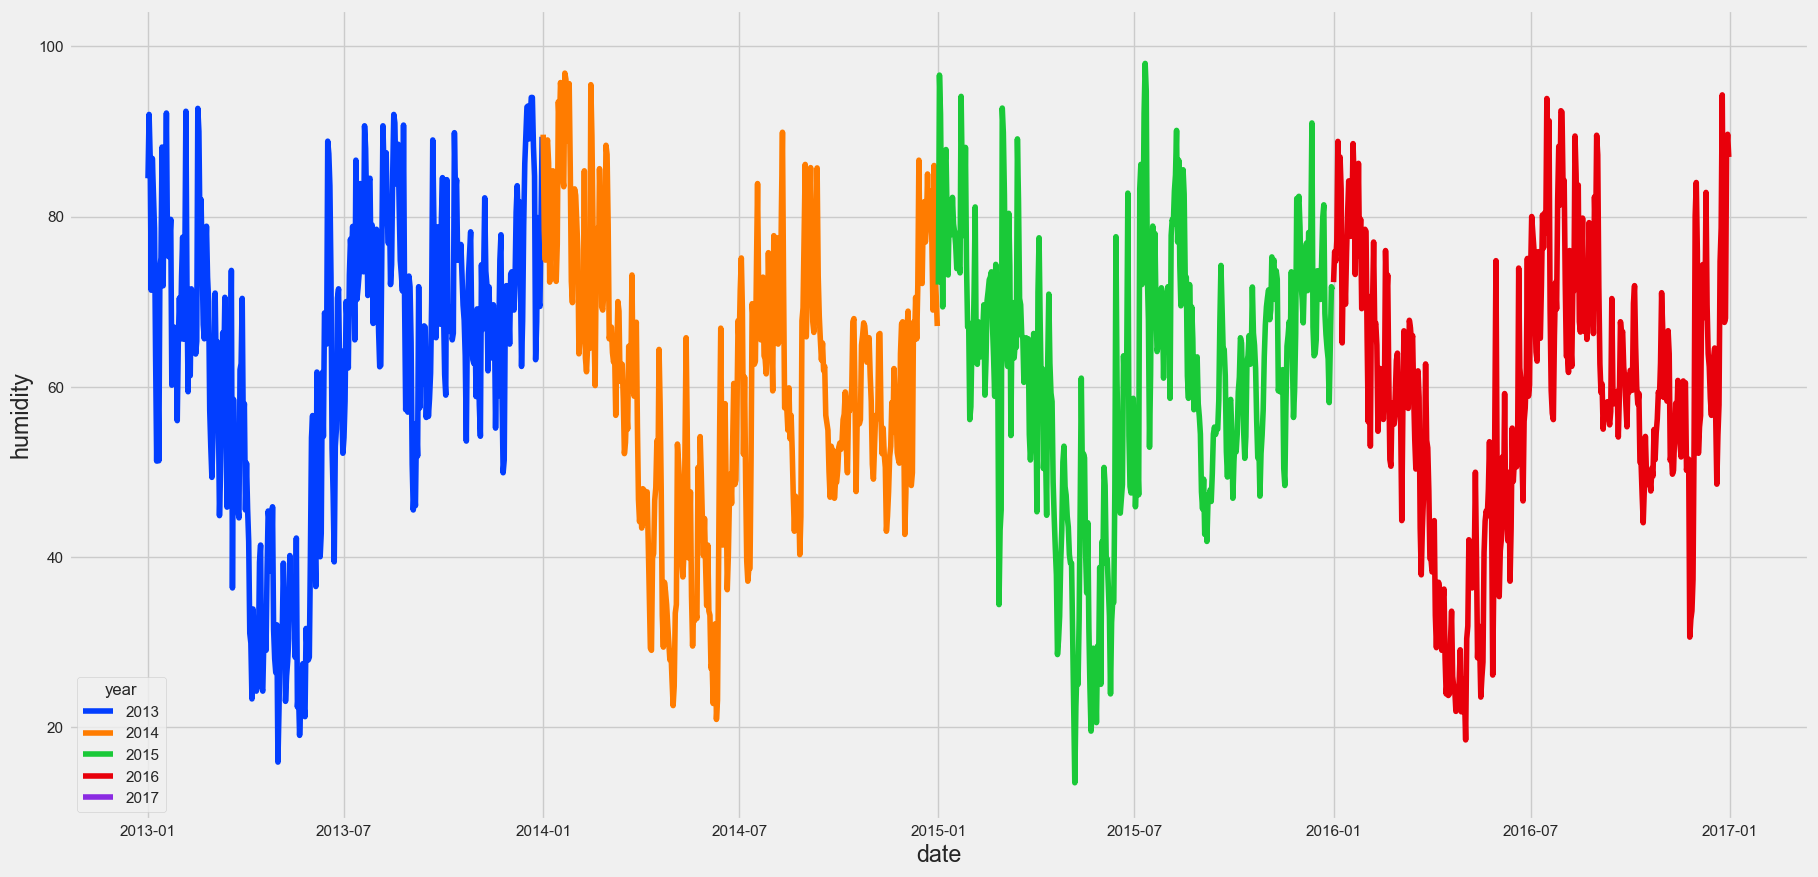

In [16]:
# 2. Exploring the change of Humidity overtime

plot_vars(df, df.index, 'humidity', 'year')

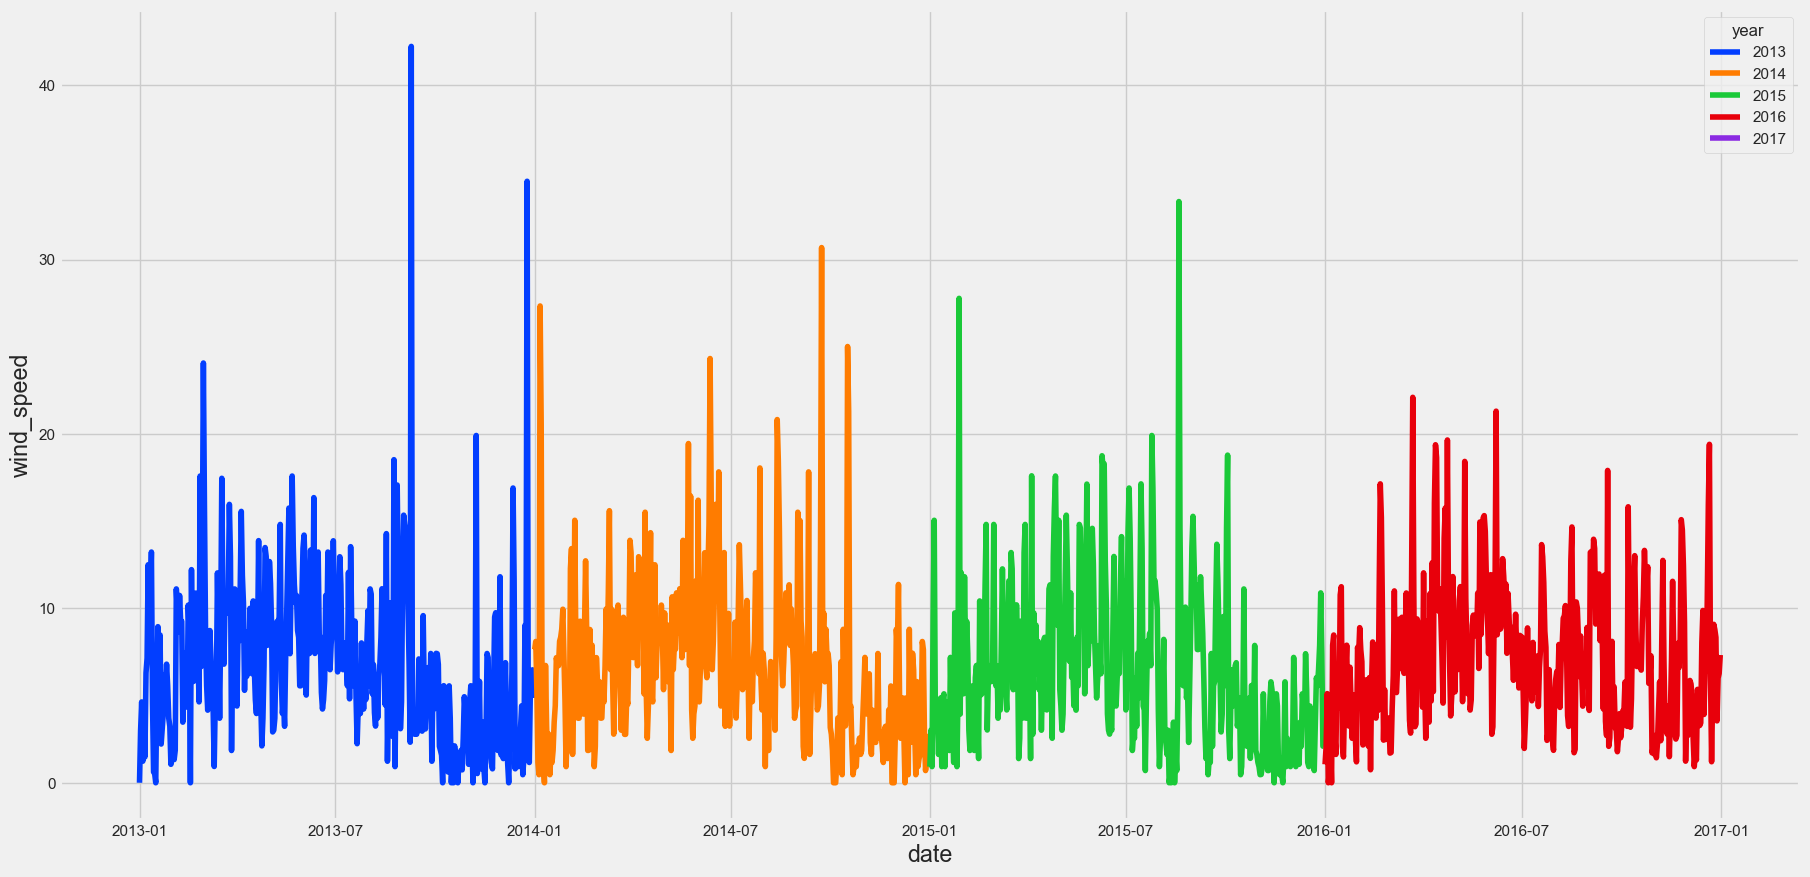

In [17]:
# 3. Exploring the change of WindSpeed overtime

plot_vars(df, df.index, 'wind_speed', 'year')

We found from the previous plot that the Wind speed at months (Aug & Sep) before 2015 was high and some how like outliers, Then after 2015 it became lower.

In [18]:
# 4. Exploring the Temprature change over years
    
def plot_change(data, x, y, year):
    fig, ax = plt.subplots(figsize=(20,10))
    
    sns.lineplot(
        ax = ax,
        data = data,
        x = x, 
        y = y,
        hue = year,
        palette = 'bright'
        
    )
    plt.show()

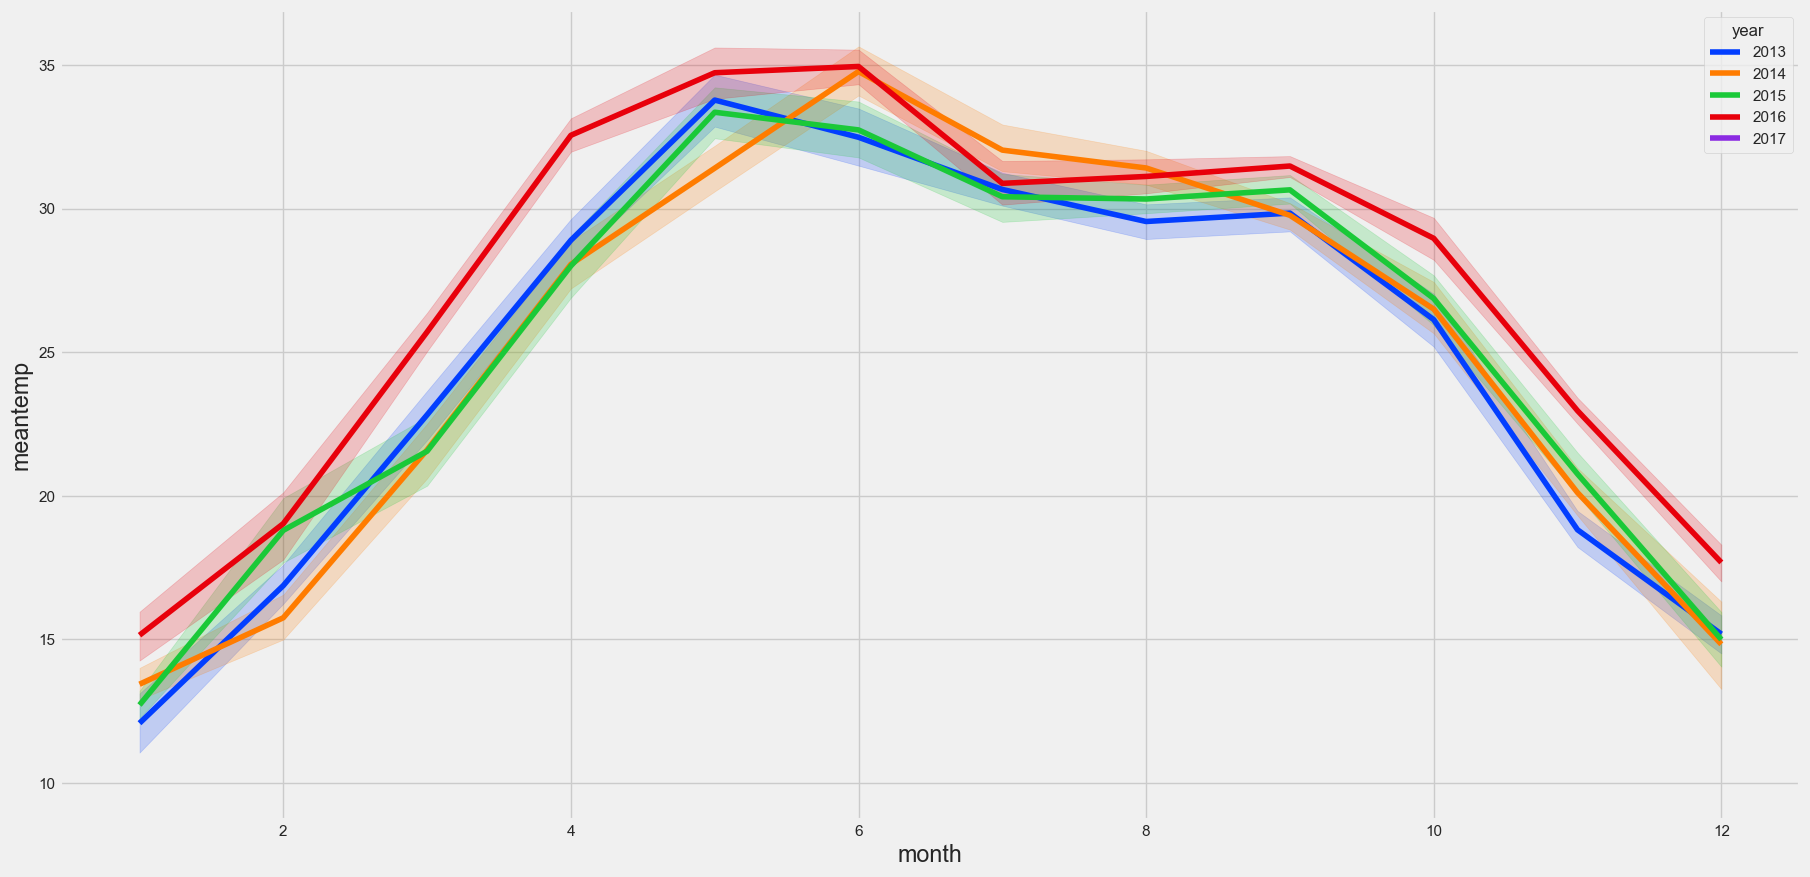

In [19]:
plot_change(df, 'month', 'meantemp', 'year')

In [20]:
# 5. Exploring the relationship between humidity and temperature

def rel_temp_hum(data, x, y):
    fig, ax = plt.subplots(figsize=(20,10))
    
    sns.scatterplot(
        ax = ax,
        data = data,
        x = x, 
        y = y,
        palette = 'flare',
        size = y,
        hue = y
    )
    plt.show()

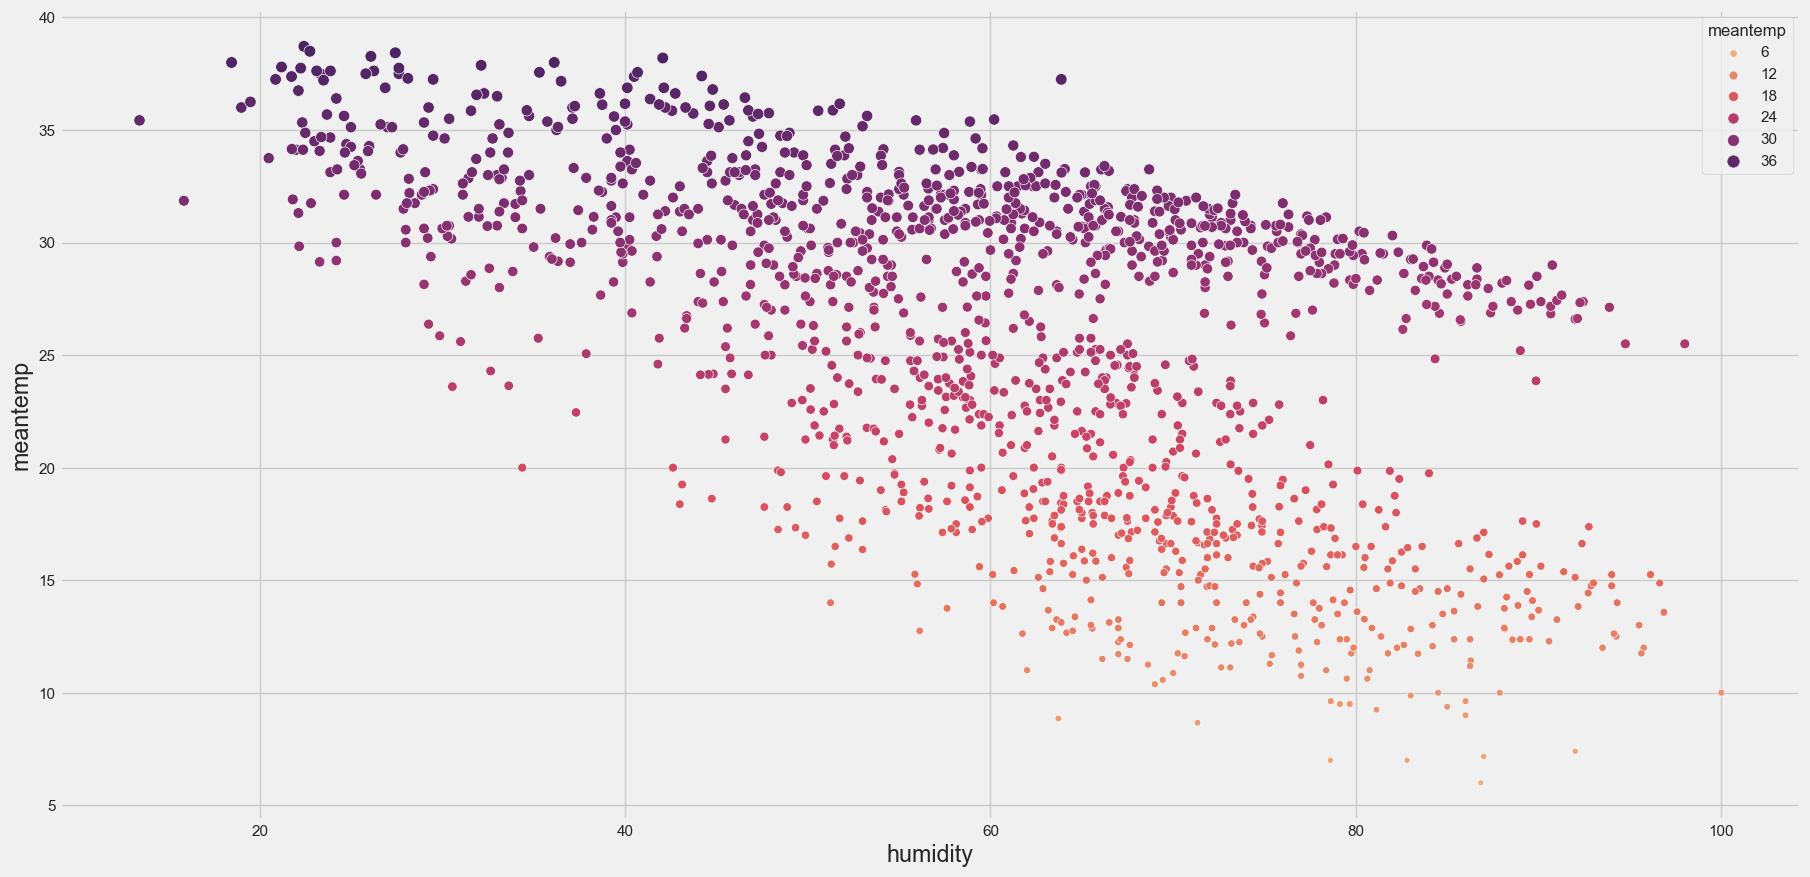

In [21]:
rel_temp_hum(df, 'humidity', 'meantemp')

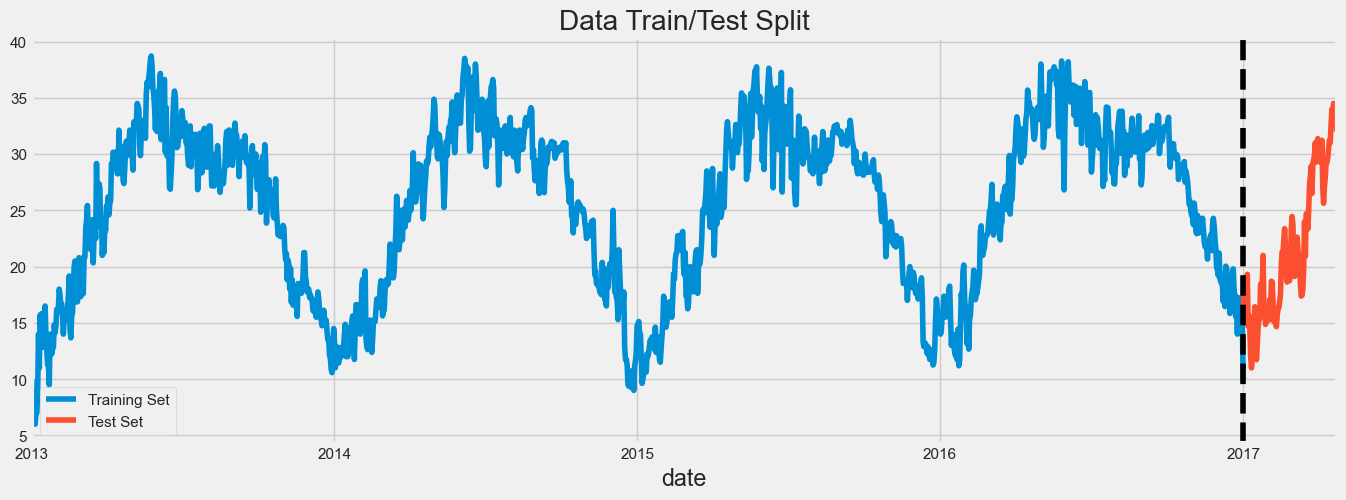

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
df['meantemp'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
tesdf['meantemp'].plot(ax=ax, label='Test Set')
ax.axvline(df.index.max(), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [23]:
# 3. Time Series Cross Validation

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=180, gap=7)
df = df.sort_index()

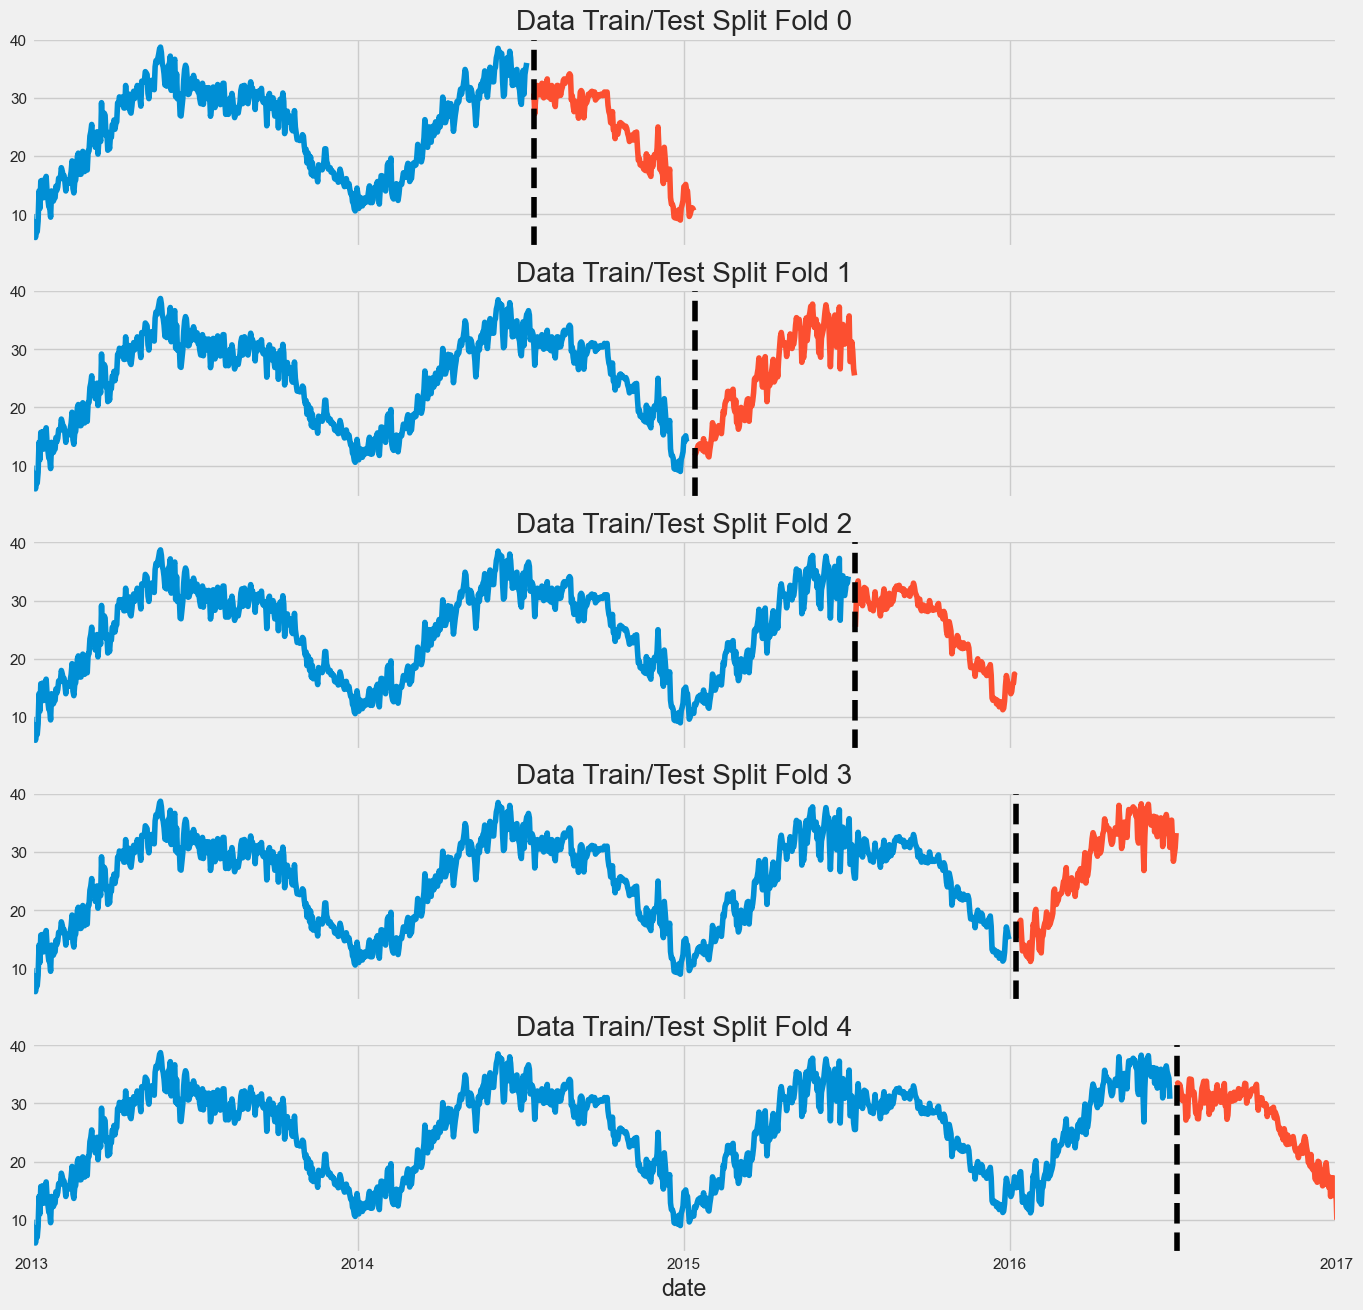

In [24]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['meantemp'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['meantemp'].plot(ax=axs[fold],
                         label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

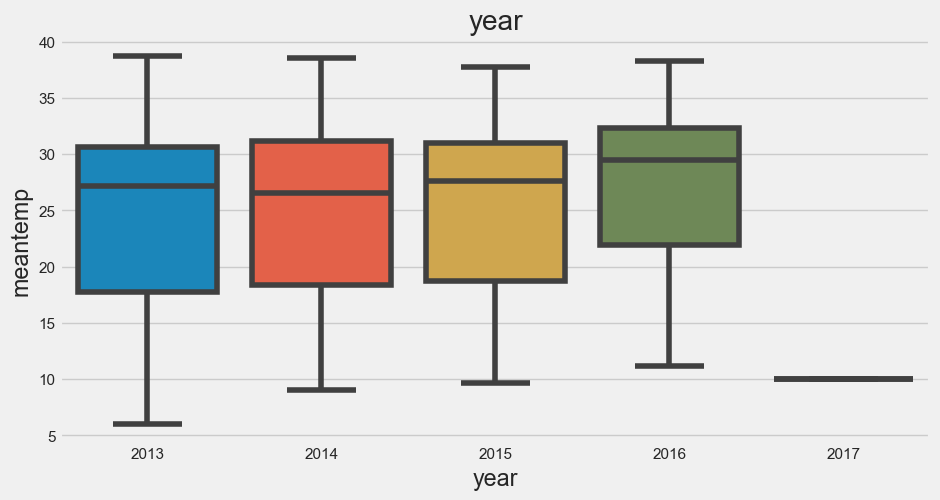

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='year', y='meantemp')
ax.set_title('year')
plt.show()

In [26]:
def add_lags(df):
    target_map = df['meantemp'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [27]:
df = add_lags(df)

In [28]:
tss = TimeSeriesSplit(n_splits=5, test_size=180, gap=7)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

  #'meanpressure',
    FEATURES = ['dayofyear','humidity','wind_speed','meanpressure', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'meantemp'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[22:11:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25.16961	validation_1-rmse:24.57489
[100]	validation_0-rmse:9.48812	validation_1-rmse:9.51886
[200]	validation_0-rmse:3.78702	validation_1-rmse:4.21519
[300]	validation_0-rmse:1.84404	validation_1-rmse:2.66674
[400]	validation_0-rmse:1.28167	validation_1-rmse:2.29762
[500]	validation_0-rmse:1.12896	validation_1-rmse:2.21662
[600]	validation_0-rmse:1.06711	validation_1-rmse:2.18137
[700]	validation_0-rmse:1.02019	validation_1-rmse:2.15075
[800]	validation_0-rmse:0.97837	validation_1-rmse:2.13276
[868]	validation_0-rmse:0.95200	validation_1-rmse:2.12948
[22:12:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now

In [29]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2.0959
Fold scores:[2.1283231708507775, 1.977345383672582, 1.8655996012944525, 2.688948603909955, 1.8194080430127688]


In [30]:
# Retrain on all data

TARGET = 'meantemp'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[22:12:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25.79586
[100]	validation_0-rmse:9.72486
[200]	validation_0-rmse:3.98238
[300]	validation_0-rmse:2.09390
[400]	validation_0-rmse:1.58239
[499]	validation_0-rmse:1.43865


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

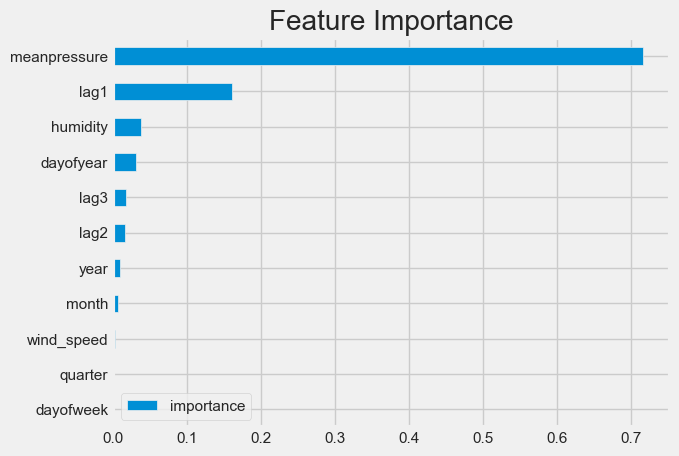

In [31]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [32]:
fi

importance
dayofyear       0.030505
humidity        0.037701
wind_speed      0.003166
meanpressure    0.717198
dayofweek       0.000000
quarter         0.000000
month           0.006414
year            0.009683
lag1            0.161518
lag2            0.016021
lag3            0.017795

In [33]:
test['prediction'] = reg.predict(X_test)
test

C:\Users\DELL\AppData\Local\Temp\ipykernel_16008\2874089957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


meantemp    humidity  wind_speed  meanpressure  year  month  \
date                                                                       
2016-07-06  33.266667   64.066667    8.878571    996.866667  2016      7   
2016-07-07  33.500000   63.000000    5.918750    997.687500  2016      7   
2016-07-08  30.800000   75.866667    5.433333    997.400000  2016      7   
2016-07-09  33.250000   66.062500    6.731250    996.750000  2016      7   
2016-07-10  32.562500   65.687500    4.700000    996.062500  2016      7   
...               ...         ...         ...           ...   ...    ...   
2016-12-28  17.217391   68.043478    3.547826   1015.565217  2016     12   
2016-12-29  15.238095   87.857143    6.000000   1016.904762  2016     12   
2016-12-30  14.095238   89.666667    6.266667   1017.904762  2016     12   
2016-12-31  15.052632   87.000000    7.325000   1016.100000  2016     12   
2017-01-01  10.000000  100.000000    0.000000   1016.000000  2017      1   

           month_of_year  dayofweek  quarter  dayofyear  dayofmonth  \
date                                                                  
2016-07-06       2016-07          2        3        188           6   
2016-07-07       2016-07          3        3        189           7   
2016-07-08       2016-07          4        3        190           8   
2016-07-09       2016-07          5        3        191           9   
2016-07-10       2016-07          6        3        192          10   
...                  ...        ...      ...        ...         ...   
2016-12-28       2016-12          2        4        363          28   
2016-12-29       2016-12          3        4        364          29   
2016-12-30       2016-12          4        4        365          30   
2016-12-31       2016-12          5        4        366          31   
2017-01-01       2017-01          6        1          1           1   

            weekofyear       lag1    lag2    lag3  prediction  
date                                                           
2016-07-06          27  31.250000  36.000  29.750   32.428070  
2016-07-07          27  29.625000  36.125  32.500   32.548893  
2016-07-08          27  26.625000  36.625  28.875   30.543070  
2016-07-09          27  25.500000  35.875  31.750   32.018414  
2016-07-10          27  25.500000  31.625  30.750   32.000103  
...                ...        ...     ...     ...         ...  
2016-12-28          52  15.500000  12.375  13.375   16.194693  
2016-12-29          52  15.000000  14.750  11.000   14.216549  
2016-12-30          52  14.714286  14.875  12.500   13.337921  
2016-12-31          52  14.000000  15.125  12.875   14.888778  
2017-01-01          52  14.375000  14.125  12.375   13.079747  

[180 rows x 16 columns]

In [34]:
test['error'] = np.abs(test['meantemp'] - test['prediction'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_16008\2858578017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test['meantemp'] - test['prediction'])


In [35]:
test[['meantemp','prediction','error']].head()

meantemp  prediction     error
date                                       
2016-07-06  33.266667   32.428070  0.838597
2016-07-07  33.500000   32.548893  0.951107
2016-07-08  30.800000   30.543070  0.256930
2016-07-09  33.250000   32.018414  1.231586
2016-07-10  32.562500   32.000103  0.562397

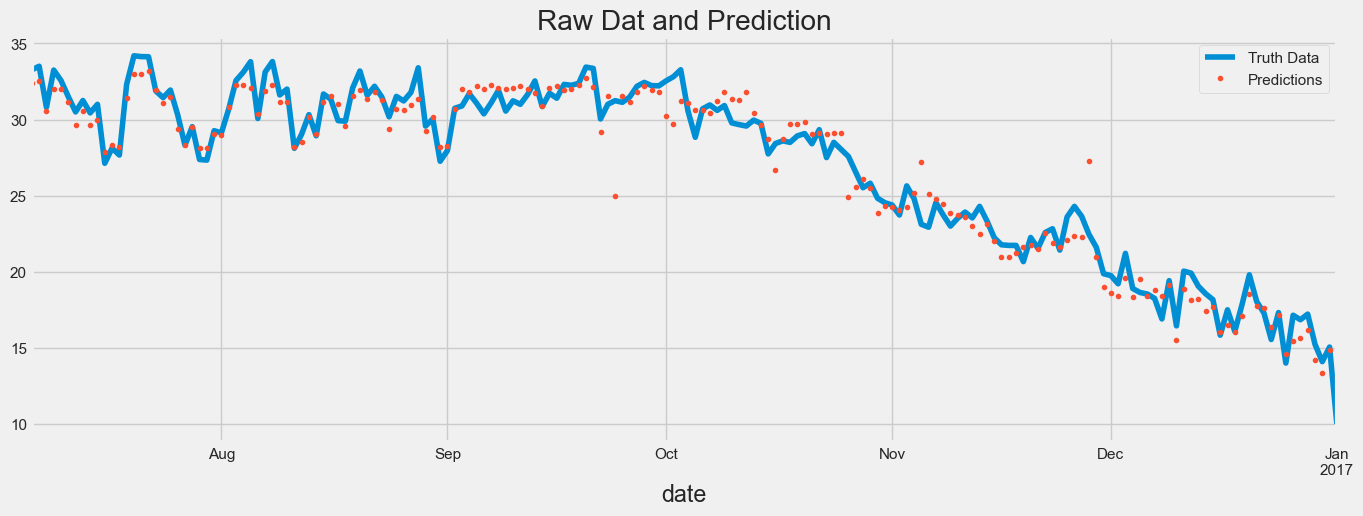

In [36]:
ax = test[['meantemp']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Making Future Predictions

In [37]:
# Create future dataframe
future = pd.date_range('2017-04-24','2018-04-24', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

# Adding new columns; month and year
future_df['year'] = future_df.index.year
future_df['month'] = future_df.index.month
future_df['month_of_year'] = future_df.index.to_period('M')
future_df['dayofweek'] = future_df.index.dayofweek
future_df['quarter'] = future_df.index.quarter
future_df['dayofyear'] = future_df.index.dayofyear
future_df['dayofmonth'] = future_df.index.day
future_df['weekofyear'] = future_df.index.isocalendar().week

In [38]:
df['isFuture'] = False

In [39]:
df_and_future = pd.concat([df, future_df])


In [40]:
future_w_features = df_and_future.query('isFuture').copy()

In [41]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

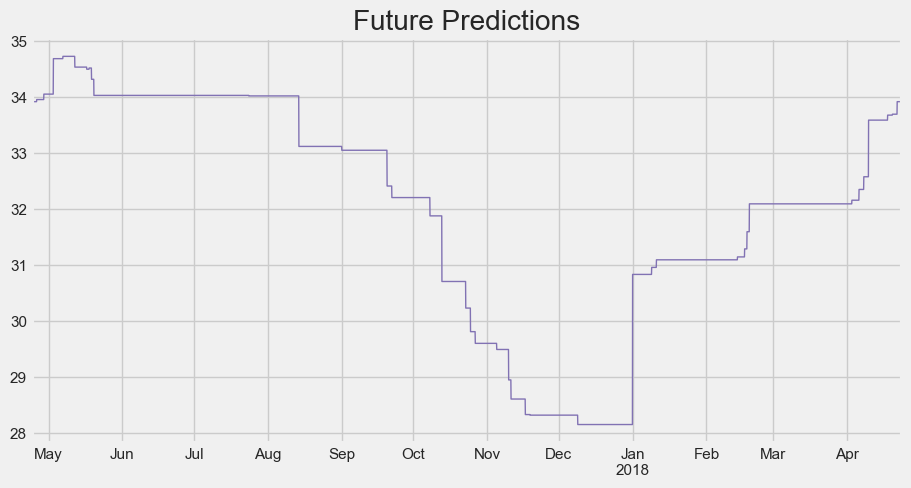

In [42]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Forecasting with Prophet

In [43]:
prophet_df = df.copy()

In [44]:
prophet_df = prophet_df.reset_index()

In [45]:
# Modeling : Using (Prophet Algorithm) which can be concidered as one of the best models to predict data with Time Series Forecasting
# 1. Set the Forcasting data
forecasdf =prophet_df.rename(columns={'date':'ds', 'meantemp':'y'})
forecasdf.head()

ds          y   humidity  wind_speed  meanpressure  year  month  \
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667  2013      1   
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000  2013      1   
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667  2013      1   
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667  2013      1   
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000  2013      1   

  month_of_year  dayofweek  quarter  dayofyear  dayofmonth  weekofyear  lag1  \
0       2013-01          1        1          1           1           1   NaN   
1       2013-01          2        1          2           2           1   NaN   
2       2013-01          3        1          3           3           1   NaN   
3       2013-01          4        1          4           4           1   NaN   
4       2013-01          5        1          5           5           1   NaN   

   lag2  lag3  isFuture  
0   NaN   NaN     False  
1   NaN   NaN     False  
2   NaN   NaN     False  
3   NaN   NaN     False  
4   NaN   NaN     False

In [46]:
# !pip install prophet

In [47]:
# 2. Modeling
from prophet import Prophet
from prophet.plot import plot_plotly

model = Prophet()
model.fit(forecasdf)
forecasts = model.make_future_dataframe(periods = 365)
predictions = model.predict(forecasts)
plot_plotly(model, predictions)

22:12:16 - cmdstanpy - INFO - Chain [1] start processing
22:12:16 - cmdstanpy - INFO - Chain [1] done processing
